In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import scipy.special
from scipy.special import comb
from scipy.optimize import minimize_scalar

import scipy
import math
import time
from sklearn.gaussian_process.kernels import RBF

from itertools import product, groupby
import random, time


In [2]:
def runs(a_list):
    runs_zeros = len([k for k, g in groupby(a_list) if k == 0])
    runs_ones = len([k for k, g in groupby(a_list) if k == 1])
    return runs_ones+runs_zeros

def tr(actions):
    if len(actions)<100:
        return 1
    else:
        return 1-0.02*(10-sum(actions[-10:-1]))/10

In [3]:
class T0_est:  
    def __init__(self, T, x, y,K,sigma,alpha,n_sim=10000,burn=0):
        self.T= T
        self.x=x
        self.y=y
        self.K=K
        self.sigma=sigma
        self.alpha=alpha
        self.n_sim=n_sim
        self.burn=burn
        self.n = y.shape[0]
        self.g = T.shape[0]
        
        self.T0_init = np.array([0, 1] * (self.g // 2))
        #self.T0_init = np.concatenate((np.ones(10),np.zeros(100),np.ones(18)))
        self.action = []
    
    def chain_builder(self):
        chain = [self.T0_init]
        for i in range(self.n_sim):
            curr=chain[-1]
            chain.append(self.next_T0(curr))
        return chain[self.burn:]
    
        
    def next_T0(self,current): 
        new = self.candidate(current)
        rate=self.acceptance_rate(current,new)
        
        treshold = tr(self.action)
        if rate>=treshold:
            print("Proposal T0 accepted with rate ", rate)
            self.action.append(1)
            return new
        
        else:
            print("Proposal T0 rejected with rate ", rate)
            self.action.append(0)
                
            return current
        
    def candidate(self,old):
        new=old.copy()
        coin = np.random.uniform(0,1,1)
        
        if coin<0.2: #split
            choices = [i for i in range(1,len(old) - 1) if old[i-1] == 1 and old[i] == 1 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                splitting_point = choice
                new[splitting_point]=0
        
        if (coin>=0.2) and (coin<0.4): #right removal
            choices = [i for i in range(0,len(old)-1) if old[i] == 1 and old[i + 1] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0
        
        if (coin>=0.4) and (coin<0.6): #left removal
            choices = [i+1 for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                removing_point = choice
                new[removing_point]=0
        
        if (coin>=0.6) and (coin<0.8): #right add
            choices = [i for i in range(1,len(old)) if old[i-1] == 1 and old[i] == 0]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if coin>=0.8: #left add
            choices = [i for i in range(0,len(old)-1) if old[i] == 0 and old[i + 1] == 1]
            if len(choices)>0:
                choice = np.random.choice(choices)
                adding_point = choice
                new[adding_point]=1

        if sum(old)==0:
            choice = np.random.choice(range(len(old)))
            new[choice]=1
        return new
        
    
    def acceptance_rate(self,current,new):   
        prior = self.PT0(current)
        prior_new = self.PT0(new)
        likl = posterior(self.T,current,self.x,self.y,self.K,self.sigma).likelihood()
        likl_new =posterior(self.T,new,self.x,self.y,self.K,self.sigma).likelihood()
        
        return (likl_new*prior_new)/(likl*prior)
            
    
    def PT0(self,current): 
        r=runs(current)          
        return np.exp(-self.alpha*r)



In [4]:
class posterior:
    def __init__(self, T, T0, x, y, K,sigma):
        self.T = T
        self.x = x
        self.y = y
        self.n = y.shape[0]
        self.g = T.shape[0]
        self.T0 = T0
        self.sigma = sigma
        self.K = K
        self.K0 = self.get_K0()
        
    def get_K0(self):
        tau = np.where(self.T0==1)[0]
        K_tau=self.K[:, tau]
        K_tau_tau = self.K[tau[:, None], tau]
        return self.K- np.transpose(K_tau @ np.linalg.inv(K_tau_tau)@ K_tau.T)  #original is transposed, but it is the same       
        
    def Lx0(self,t):   
        L = np.zeros(self.n)    
        for i in np.arange(0,self.n):
            L[i] = np.trapz(self.K0[t, :] * self.x[i,:], self.T)
        return L
    
    def R0(self,i, j):
        Ri = np.trapz(self.K0[:, :] * self.x[i, :], self.T, axis=1)
        Rij = np.trapz(Ri * self.x[j, :],self.T)
        return Rij

    def M(self):
        return np.array([[self.R0(i, j) for j in range(self.n)] for i in range(self.n)])+np.identity(self.n)
    

    def likelihood(self): #p(Y|T0) 
        m_matrix = self.M()
        first = np.linalg.det(m_matrix) ** (-0.5)

        
        inv = np.linalg.inv(m_matrix)
        s11 = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),np.ones(self.n))
        
        syy = np.dot(np.dot(np.transpose(self.y),inv),self.y)
        s1y = np.dot(np.dot(np.transpose(np.ones(self.n)),inv),self.y)
        b = 0.5*(syy-s1y**2/s11)
            
        return first/np.sqrt(s11)*(b**(-0.5*(n-1)))


## Example

In [5]:
g=128
T = np.linspace(-3,3,g)
T0_real = T[np.where((T >= -1) & (T <= 0.5))]

T0_01 = np.zeros(g)
for i in range(g):
    if (T[i]>=-1) and (T[i]<=0.5):
        T0_01[i]=1


step = T[1]-T[0]
n = 30
alpha = 4
sigma = 0.25

def integrate(T, f): 
    return np.trapz(f,T)

def prior_kernel(s,t):
    return np.exp(-2*(t-s)**2)+0.0001*(s==t)

def proj(K,T,T0,f): 
    tau = np.where(T0==1)[0]
    K_tau=K[:, tau]
    K_tau_tau = K[tau[:, None], tau]
    beta_tau = f[tau] 
    
    proj = f-np.dot(K_tau,np.dot(np.linalg.inv(K_tau_tau),beta_tau))
    
    return proj

K = np.zeros((g, g))
K = np.fromfunction(np.vectorize(lambda s, t: prior_kernel(T[s], T[t])), (g, g), dtype=int) 
x = np.random.multivariate_normal(np.zeros(g), K, n)


In [6]:
beta = np.sin(T*math.pi/4)
beta0 = proj(K,T,T0_01,beta)

y = np.zeros(n)
y = np.fromfunction(np.vectorize(lambda i: integrate(T,  x[i,:]*beta0)+np.random.normal(0,sigma,1)), (n,), dtype=int)

In [7]:
post = T0_est(T, x, y, K, sigma, alpha, 1000)

chain = post.chain_builder()

Proposal T0 accepted with rate  2980.9738203589295
Proposal T0 accepted with rate  2980.7287510311817
Proposal T0 rejected with rate  0.00033548842700096426
Proposal T0 accepted with rate  2980.972231858965
Proposal T0 rejected with rate  0.0003354884089639801
Proposal T0 accepted with rate  2980.940890636167
Proposal T0 accepted with rate  2981.419367037108
Proposal T0 accepted with rate  2980.9719654715286
Proposal T0 accepted with rate  2980.978639902418
Proposal T0 accepted with rate  2981.467236885943
Proposal T0 rejected with rate  0.0003354610511488863
Proposal T0 accepted with rate  2980.9864247008863
Proposal T0 accepted with rate  2980.9258844735264
Proposal T0 accepted with rate  2981.4192752185963
Proposal T0 accepted with rate  2981.0943749769676
Proposal T0 accepted with rate  2980.9463442191036
Proposal T0 accepted with rate  2981.021464223853
Proposal T0 rejected with rate  0.999984597919666
Proposal T0 accepted with rate  2980.5377239525947
Proposal T0 accepted with ra

Proposal T0 accepted with rate  0.9999785962137182
Proposal T0 accepted with rate  1.0000028020511718
Proposal T0 accepted with rate  0.9999820371847947
Proposal T0 accepted with rate  0.9999910615557163
Proposal T0 accepted with rate  1.0000057126695303
Proposal T0 accepted with rate  0.999987075955291
Proposal T0 rejected with rate  0.00033546241819276744
Proposal T0 rejected with rate  0.923942578027039
Proposal T0 rejected with rate  0.923942578027039
Proposal T0 accepted with rate  1.0001538838579878
Proposal T0 accepted with rate  2980.947704594645
Proposal T0 accepted with rate  1.000070146444093
Proposal T0 accepted with rate  1.0000958471085666
Proposal T0 accepted with rate  1.0000362206254056
Proposal T0 accepted with rate  3192.103800635738
Proposal T0 rejected with rate  0.0003356933587744937
Proposal T0 accepted with rate  0.9973218931286592
Proposal T0 accepted with rate  0.9999376000198577
Proposal T0 rejected with rate  0.00033569473018564756
Proposal T0 accepted with 

Proposal T0 accepted with rate  1.079331195269831
Proposal T0 accepted with rate  0.9999092227262164
Proposal T0 rejected with rate  0.000334981346514267
Proposal T0 accepted with rate  2.2226027527450944
Proposal T0 accepted with rate  0.9999689485879698
Proposal T0 accepted with rate  1.0057938496109255
Proposal T0 accepted with rate  1.0000434307118014
Proposal T0 accepted with rate  2.05674392534799
Proposal T0 rejected with rate  0.4862053985796046
Proposal T0 rejected with rate  0.00034276058765832717
Proposal T0 accepted with rate  0.9951799290370613
Proposal T0 rejected with rate  0.48666156761095514
Proposal T0 accepted with rate  0.9981978273328723
Proposal T0 accepted with rate  1.0049205356064872
Proposal T0 accepted with rate  0.9951035575131145
Proposal T0 accepted with rate  0.9998412547158083
Proposal T0 rejected with rate  0.0003365615299815203
Proposal T0 rejected with rate  0.4866281964469168
Proposal T0 accepted with rate  0.9915468235623226
Proposal T0 accepted wit

Proposal T0 rejected with rate  0.8767235471148435
Proposal T0 rejected with rate  0.0003361054407046985
Proposal T0 rejected with rate  0.00033603037839542986
Proposal T0 rejected with rate  0.9797030238498396
Proposal T0 rejected with rate  0.9797030238498396
Proposal T0 rejected with rate  0.00033699318957593655
Proposal T0 accepted with rate  1.016335390362133
Proposal T0 rejected with rate  0.98392716566102
Proposal T0 rejected with rate  0.0003366560560612751
Proposal T0 rejected with rate  0.00033719406898031806
Proposal T0 accepted with rate  0.9915684458947546
Proposal T0 rejected with rate  0.9591586063360353
Proposal T0 rejected with rate  0.0003360762755654632
Proposal T0 rejected with rate  0.8721062603329045
Proposal T0 accepted with rate  0.9920655612938533
Proposal T0 rejected with rate  0.0003367652519214132
Proposal T0 accepted with rate  1.0810551359003688
Proposal T0 accepted with rate  1.0088230362907735
Proposal T0 accepted with rate  0.9912541288477968
Proposal T

Proposal T0 accepted with rate  0.9868038087175284
Proposal T0 rejected with rate  0.8497974066580463
Proposal T0 rejected with rate  0.8750698749121955
Proposal T0 rejected with rate  0.00033571455540778344
Proposal T0 accepted with rate  0.9921667209482572
Proposal T0 rejected with rate  0.0003360915518275872
Proposal T0 accepted with rate  1.0078951237592975
Proposal T0 rejected with rate  0.8750698749121955
Proposal T0 accepted with rate  0.9922654696984284
Proposal T0 accepted with rate  0.9973622108642595
Proposal T0 accepted with rate  1.013044812371485
Proposal T0 rejected with rate  0.9871231635440214
Proposal T0 rejected with rate  0.9819974678523459
Proposal T0 accepted with rate  1.0028014572866368
Proposal T0 rejected with rate  0.9719760502711495
Proposal T0 accepted with rate  0.9972063689514203
Proposal T0 rejected with rate  0.00033483886536390966
Proposal T0 rejected with rate  0.9819974678523459
Proposal T0 accepted with rate  0.9978874432672364
Proposal T0 accepted 

Proposal T0 rejected with rate  0.0003355302619378556
Proposal T0 rejected with rate  0.00033485447261670737
Proposal T0 rejected with rate  0.0003357619611176341
Proposal T0 rejected with rate  0.0003356386162133713
Proposal T0 rejected with rate  0.0003356386162133713
Proposal T0 rejected with rate  0.9782541255180087
Proposal T0 rejected with rate  0.00033492768138520027
Proposal T0 rejected with rate  0.9454861958715849
Proposal T0 rejected with rate  0.9454861958715849
Proposal T0 accepted with rate  1.0011979126576287
Proposal T0 rejected with rate  0.934820549330766
Proposal T0 accepted with rate  1.0026981745035042
Proposal T0 rejected with rate  0.9465337236254967
Proposal T0 accepted with rate  0.9973090860519018
Proposal T0 accepted with rate  1.0028004578512992
Proposal T0 accepted with rate  0.9981468648447163
Proposal T0 rejected with rate  0.9628880052480274
Proposal T0 rejected with rate  0.9628880052480274
Proposal T0 rejected with rate  0.9874438437659657
Proposal T0 

Proposal T0 rejected with rate  0.0003350901326813286
Proposal T0 rejected with rate  0.9891921798037103
Proposal T0 rejected with rate  0.9891208814771525
Proposal T0 accepted with rate  0.9916839736452286
Proposal T0 rejected with rate  0.903777015264177
Proposal T0 rejected with rate  0.0003366957667381754
Proposal T0 accepted with rate  1.0083857625773696
Proposal T0 accepted with rate  0.9891208814771525
Proposal T0 rejected with rate  0.00033497242679994657
Proposal T0 rejected with rate  0.9061189573188745
Proposal T0 accepted with rate  1.0109987755051744
Proposal T0 accepted with rate  0.9891921798037103
Proposal T0 rejected with rate  0.0003354096928370588
Proposal T0 accepted with rate  0.9963066190523479
Proposal T0 accepted with rate  0.9888559770153161
Proposal T0 rejected with rate  0.9526909546164489
Proposal T0 rejected with rate  0.9685682405886885
Proposal T0 accepted with rate  1.0004630280244429
Proposal T0 rejected with rate  0.00033657964866578346
Proposal T0 rej

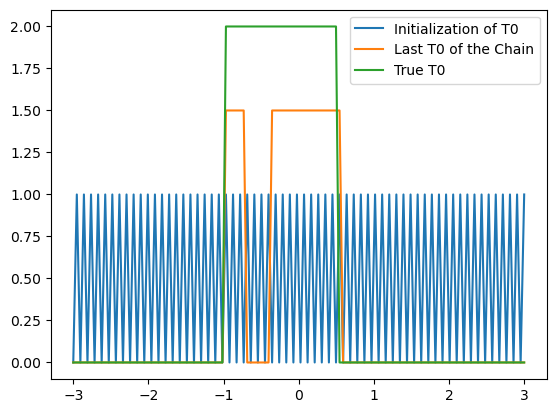

In [8]:
plt.plot(T,post.T0_init,label='Initialization of T0')
plt.plot(T,1.5*np.array(chain[-1]),label='Last T0 of the Chain')
plt.plot(T,2*T0_01,label='True T0')
plt.legend()